# 资讯类APP用户增长分析

## 一、数据理解

数据来自某资讯类APP平台的用户交互数据，
数据链接：
* articles.csv：     http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531842/articles.csv
* testA_click_log.csv：http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531842/testA_click_log.csv
* train_click_log.csv：http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531842/train_click_log.csv 


In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency

import time
import datetime
from datetime import datetime,timedelta

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

from pyecharts.charts import Line
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
import random
from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST

from sklearn import preprocessing

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")



**读取数据**

In [2]:
path = 'F:\工作资料\项目管理_DA\资讯类APP用户增长分析\\data' 
trn_click = pd.read_csv(path+'train_click_log.csv')
tst_click = pd.read_csv(path+'testA_click_log.csv')

item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match

**数据浏览**

In [3]:
#数据合并
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
user_click_merge = trn_click.append(tst_click)
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,209,1506938444000,185


In [4]:
user_click_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630633 entries, 0 to 518009
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1630633 non-null  int64
 1   click_article_id     1630633 non-null  int64
 2   click_timestamp      1630633 non-null  int64
 3   click_environment    1630633 non-null  int64
 4   click_deviceGroup    1630633 non-null  int64
 5   click_os             1630633 non-null  int64
 6   click_country        1630633 non-null  int64
 7   click_region         1630633 non-null  int64
 8   click_referrer_type  1630633 non-null  int64
 9   category_id          1630633 non-null  int64
 10  created_at_ts        1630633 non-null  int64
 11  words_count          1630633 non-null  int64
dtypes: int64(12)
memory usage: 161.7 MB


**数据清洗**

In [5]:
user_click_merge.drop_duplicates(keep='last',inplace=True)#删除重复值

将时间戳转换为datetime格式

In [6]:
user_click_merge['click_time'] = user_click_merge.click_timestamp.apply(lambda x: datetime.fromtimestamp(x/1000))
user_click_merge['click_time'] = pd.to_datetime(user_click_merge.click_time)

提取时间

In [7]:
user_click_merge['date'] = user_click_merge.click_time.dt.date
user_click_merge['hour'] = user_click_merge.click_time.dt.hour
user_click_merge['week'] = user_click_merge.click_time.dt.weekday+1

In [8]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,words_count,click_time,date,hour,week
0,199999,160417,1507029570190,4,1,17,1,13,1,281,1506942089000,173,2017-10-03 19:19:30.190,2017-10-03,19,2
1,199999,5408,1507029571478,4,1,17,1,13,1,4,1506994257000,118,2017-10-03 19:19:31.478,2017-10-03,19,2
2,199999,50823,1507029601478,4,1,17,1,13,1,99,1507013614000,213,2017-10-03 19:20:01.478,2017-10-03,19,2
3,199998,157770,1507029532200,4,1,17,1,25,5,281,1506983935000,201,2017-10-03 19:18:52.200,2017-10-03,19,2
4,199998,96613,1507029671831,4,1,17,1,25,5,209,1506938444000,185,2017-10-03 19:21:11.831,2017-10-03,19,2


获取值的种类数

In [9]:
user_click_merge.nunique()

user_id                 250000
click_article_id         35380
click_timestamp        1628989
click_environment            3
click_deviceGroup            5
click_os                     8
click_country               11
click_region                28
click_referrer_type          7
category_id                297
created_at_ts            35187
words_count                509
click_time             1628989
date                        35
hour                        24
week                         7
dtype: int64

## 二、AARRR模型

### A：获取用户——渠道分析
**数据准备**

选择用户id、文章id、点击时间戳、来源字段，并统计每个用户所有文章点击次数

In [10]:
referrer_data = user_click_merge[['user_id','click_article_id','click_timestamp','click_referrer_type']]
referrer_data['click_counts'] = referrer_data.groupby(['user_id'])['click_timestamp'].transform('count')
referrer_data = pd.DataFrame(referrer_data)
referrer_data.head()
#referrer_data.info()

,user_id,click_article_id,click_timestamp,click_referrer_type,click_counts
0,199999,160417,1507029570190,1,11
1,199999,5408,1507029571478,1,11
2,199999,50823,1507029601478,1,11
3,199998,157770,1507029532200,5,40
4,199998,96613,1507029671831,5,40


**数据分析**

按渠道分类，统计并计算用户数、点击数、文章数、跳失数、跳失率、平均点击数、平均阅读数。

In [11]:
referrer_DA = referrer_data.groupby('click_referrer_type').agg(
        用户数 = ("user_id",lambda x : x.nunique()),
        点击数 = ("click_timestamp", lambda x : x.count()),
        文章数 = ("click_article_id",lambda x : x.nunique()),
        跳失数 = ("click_counts" ,lambda x : x.loc[x==1].count())
).reset_index().rename(columns={'click_referrer_type':'渠道'})
referrer_DA['跳失率']=(referrer_DA['跳失数'] /referrer_DA['用户数']).apply(lambda x:'%.2f%%' % (x*100))
referrer_DA['平均点击数']=(referrer_DA['点击数'] /referrer_DA['用户数']).apply(lambda x:'%.2f'%x)
referrer_DA['平均阅读数']=(referrer_DA['文章数'] /referrer_DA['用户数']).apply(lambda x:'%.2f'%x)
referrer_DA = pd.DataFrame(referrer_DA)
referrer_DA.head(7)

,渠道,用户数,点击数,文章数,跳失数,跳失率,平均点击数,平均阅读数
0,1,106757,616652,19267,1793,1.68%,5.78,0.18
1,2,174301,898189,9048,6404,3.67%,5.15,0.05
2,3,117,305,133,6,5.13%,2.61,1.14
3,4,5473,11787,3590,175,3.20%,2.15,0.66
4,5,22583,52804,19490,668,2.96%,2.34,0.86
5,6,5446,13627,2326,158,2.90%,2.50,0.43
6,7,13058,37269,6920,316,2.42%,2.85,0.53


**业务层面分析**

注：
由于缺少行为字段，故选择一个月内点击次数为1的用户为跳失用户；
缺少成本字段，无法对渠道投放成本进行分析，只针对不同渠道的用户质量进行分析

* 渠道1的用户数较多且跳失率最低，虽然渠道1用户数小于渠道2，但是用户阅读兴趣相较渠道2更广泛，推测用户群体较年轻，是一个不错的投放渠道；
* 渠道2的用户数、点击数最多但跳失率偏高，需进一步分析阅读时长、渠道拉新能力等分析跳失率偏高的原因再制定相应策略；
* 渠道3的用户数最少、跳失率最高，虽然平均访问数处在中游，但是样本太少不具备参考价值，建议结合投入成本分析制定策略；
* 渠道4、6的整体数据相差不大，建议结合投入成本分析制定策略；
* 渠道5 、7的用户数和点击数都处于中游，且跳失率像度较低、阅读相对较广泛，可作为重点培养渠道；

**商业决策分析**

根据以上分析内容，在不考虑成本的前提下，建议加大对渠道1、5、7的投入，渠道2作进一步观察分析，放弃渠道3、4、6。


## A：用户激活——活跃度分析、重复点击分析

### 1、活跃度分析

**数据准备**

选择用户id、点击时间戳、点击日期、点击时段、点击星期

In [12]:
activity_data = user_click_merge[['user_id','click_timestamp','date','hour','week']]
activity_data.head()

,user_id,click_timestamp,date,hour,week
0,199999,1507029570190,2017-10-03,19,2
1,199999,1507029571478,2017-10-03,19,2
2,199999,1507029601478,2017-10-03,19,2
3,199998,1507029532200,2017-10-03,19,2
4,199998,1507029671831,2017-10-03,19,2


#### 1. 日活分析

按点击日期分类，统计并计算活跃用户数、点击数、活跃率、活跃用户增长率。

In [13]:
DAU = activity_data.groupby('date').agg(
        活跃用户数 = ("user_id",lambda x : x.nunique()),
        点击数 = ("click_timestamp", lambda x : x.count())
).reset_index().rename(columns={'date':'日期'})
DAU['活跃率(%)']=(DAU['活跃用户数'] /250000).apply(lambda x:'%.4f'% (x*100))
DAU['活跃用户增长率(%)']=DAU['活跃用户数'].pct_change().apply(lambda x:'%.2f'% (x*100))
DAU = pd.DataFrame(DAU)
DAU[13:18]

,日期,活跃用户数,点击数,活跃率(%),活跃用户增长率(%)
13,2017-10-15,15867,42203,6.3468,-45.07
14,2017-10-16,35229,95021,14.0916,122.03
15,2017-10-17,21245,55191,8.4980,-39.69
16,2017-10-18,93,273,0.0372,-99.56
17,2017-10-19,32,74,0.0128,-65.59


In [14]:
#可视化
bar = (Bar()
       .add_xaxis(DAU['日期'][:17].tolist())
       .add_yaxis('活跃用户数', DAU['活跃用户数'].tolist())
       .add_yaxis('点击数', DAU['点击数'].tolist())
       .set_global_opts(title_opts=opts.TitleOpts(title="DAU分析"))
       .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False))
       .extend_axis(
        yaxis=opts.AxisOpts(
            type_="value",
            name="活跃用户增长率",
            min_=-100,
            max_=150,
            position="rigt",
            axislabel_opts=opts.LabelOpts(formatter="{value} %"), interval=50,
            splitline_opts=opts.SplitLineOpts( is_show=True, linestyle_opts=opts.LineStyleOpts(opacity=1))
        )))  
      
line = (Line()
       .add_xaxis(DAU['日期'][2:17].tolist())
       .add_yaxis('活跃用户增长率', DAU['活跃用户增长率(%)'][2:17].tolist(),yaxis_index=1)
       .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
       )
bar.overlap(line)
bar.render_notebook()

**业务角度分析**

注：从日活分析得到的表中可以看到数据在10-18出现断崖式下跌，且之后数据样本太小，故可视化部分使用10-02至10-18的数据。
* 在10-03这天日活突增之后开始下降，可能是推出了拉新活动，目前来看效果不错，另外一个峰值出现在10-10这天，并且这两天都是周二，具体原因需要进一步分析
* 日活在10-18出现下跌的原因推测有以下几点：
    * 内因：
     1. 某个区域、某种机型出现大规模故障，导致用户无法登录或使用
     2. 系统更新故障或某个功能失效导致用户大规模无法登录或使用
     3. 系统全面升级，暂停使用
    * 外因：
     1. 软件违反某项政策规定，停止运营

#### 2.时段分布

按点击时段分类，统计并计算活跃用户数、点击数。

In [15]:
activity_hour = activity_data.groupby('hour').agg(
        活跃用户数 = ("user_id",lambda x : x.nunique()),
        点击数 = ("click_timestamp", lambda x : x.count())
).reset_index().rename(columns={'hour':'时段'})
activity_hour.head()

,时段,活跃用户数,点击数
0,0,39222,118442
1,1,38102,113210
2,2,38037,112781
3,3,38748,115354
4,4,36603,107162


In [16]:
bar = (Bar()
       .add_xaxis(activity_hour['时段'].tolist())
       .add_yaxis('活跃用户数', activity_hour['活跃用户数'].tolist())
       .add_yaxis('点击数', activity_hour['点击数'].tolist())
       .set_global_opts(title_opts=opts.TitleOpts(title="时段分布"))
       .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值")]))
       )
bar.render_notebook()

#### 3.周分布

按点击星期分类，统计并计算活跃用户数、点击数。

In [17]:
activity_week = activity_data.groupby('week').agg(
        活跃用户数 = ("user_id",lambda x : x.nunique()),
        点击数 = ("click_timestamp", lambda x : x.count())
).reset_index().rename(columns={'week':'星期'})
activity_week.head()

,星期,活跃用户数,点击数
0,1,63549,194602
1,2,111911,414312
2,3,77914,270158
3,4,69262,224994
4,5,69466,227558


In [18]:
bar = (Bar()
       .add_xaxis(activity_week['星期'].tolist())
       .add_yaxis('活跃用户数', activity_week['活跃用户数'].tolist())
       .add_yaxis('点击数', activity_week['点击数'].tolist())
       .set_global_opts(title_opts=opts.TitleOpts(title="星期分布"))
       .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(
            data=[
                opts.MarkPointItem(type_="max", name="最大值"),
                opts.MarkPointItem(type_="min", name="最小值")]))
       )
bar.render_notebook()

**业务角度分析**

* 从时段分布可以看出，用户活动主要集中在每天19-24时和0-4时之间，推测是因为这个时间段状态比较放松，也侧面反映出白天工作压力大
* 从周分布可以看出，用户活动主要集中在周二，结合之前日活分析，针对这一天用户的偏好、行为等可以做进一步分析
* 综上可以初步得出用户群体主要为打工族，且睡眠质量欠佳

**商业角度分析**

* 在活跃时段集中向用户推送个性化内容、软广等
* 向活跃时段倾斜资源并提供足够支持

### 2、重复点击分析

**数据准备**

按用户id、文章id分类，统计对应的重复点击次数

In [19]:
click_count_data = user_click_merge.groupby(['user_id', 'click_article_id']).agg(
                                    counts = ("click_timestamp", lambda x : x.count())
).reset_index()
click_count_data = pd.DataFrame(click_count_data)
click_count_data.head()

,user_id,click_article_id,counts
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1


**数据分析**

按重复点击次数分类，统计活跃用户数、文章数、重复点击用户所占比例

In [20]:
click_count = click_count_data.groupby('counts').agg(
                                活跃用户数 = ("user_id",lambda x : x.nunique()),
                                文章数 = ("click_article_id",lambda x : x.nunique())
).reset_index().rename(columns = {'counts':'重复点击次数'})
click_count['用户比例'] = click_count['活跃用户数'].apply(lambda x :format(x/click_count['活跃用户数'].sum(),'.4%'))
click_count.head(9)

,重复点击次数,活跃用户数,文章数,用户比例
0,1,249924,35133,96.5651%
1,2,8470,2783,3.2726%
2,3,326,285,0.1260%
3,4,55,73,0.0213%
4,5,23,25,0.0089%
5,6,10,12,0.0039%
6,7,3,3,0.0012%
7,10,2,4,0.0008%
8,13,1,1,0.0004%


可以看到只存在极少数用户多次重复点击一篇文章，故不存在恶意刷量的情况

## R：提高留存——留存率分析

### 1、留存率分析

**数据准备**

选择用户id、点击日期字段

In [21]:
cohort_data = user_click_merge[['user_id','date']]
cohort_data.head()

,user_id,date
0,199999,2017-10-03
1,199999,2017-10-03
2,199999,2017-10-03
3,199998,2017-10-03
4,199998,2017-10-03


**数据分析**

1. 记录用户本月内最早登陆时间，对同一最早登陆日期的客户按照下一次访问日期进行分组
2. 按照首次访问的时间，和下一次访问的间隔，统计用户数
3. 按照用户ID去重计数每一个分组的用户数
4. 创建区分最早登陆日期和下一次访问日期的用户数量的数据表
5. 数据可视化展示

In [22]:
# 第一步
grouping = cohort_data.groupby("user_id")["date"]
cohort_data["min_day"] = grouping.transform("min")
cohort_data["cohort_index"] = (((cohort_data["date"] - cohort_data["min_day"]) // 3) + timedelta(days=1)).apply(
    lambda x: x.days)
cohort_data.head()

,user_id,date,min_day,cohort_index
0,199999,2017-10-03,2017-10-03,1
1,199999,2017-10-03,2017-10-03,1
2,199999,2017-10-03,2017-10-03,1
3,199998,2017-10-03,2017-10-03,1
4,199998,2017-10-03,2017-10-03,1


In [23]:
# 第二步
grouping = cohort_data.groupby(["min_day","cohort_index"])
# 第三步
cohort = grouping["user_id"].apply(pd.Series.nunique)
# 第四步
cohort = cohort.reset_index()
cohort.head()

,min_day,cohort_index,user_id
0,2017-10-02,1,1105
1,2017-10-02,2,509
2,2017-10-02,3,478
3,2017-10-02,4,442
4,2017-10-02,5,296


In [24]:
# 第五步
# 数据透视表
cohort_counts = cohort.pivot(index="min_day",columns="cohort_index",values="user_id").rename(columns = {
    1:'D1', 2:'D2',3:'D3',4:'D4',5:'D5',6:'D6',7:'D7', 8:'D8', 9:'D9',10:'D10'})
cohort_counts.head()

cohort_index,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
min_day,,,,,,,,,,
2017-10-02,1105.0,509.0,478.0,442.0,296.0,116.0,NaN,NaN,NaN,NaN
2017-10-03,58267.0,21549.0,25773.0,19056.0,14846.0,34.0,1.0,1.0,NaN,NaN
2017-10-04,28663.0,8013.0,11656.0,6254.0,5538.0,5.0,1.0,1.0,NaN,NaN
2017-10-05,20603.0,6418.0,6282.0,4324.0,1553.0,4.0,2.0,NaN,NaN,NaN
2017-10-06,22358.0,7256.0,5079.0,3651.0,11.0,4.0,2.0,NaN,NaN,NaN


In [25]:
# 百分位展示
cohort_size = cohort_counts.iloc[:,0]
retention_table = cohort_counts.divide(cohort_size,axis=0)
retention_table.round(3) * 100
retention_table.index = retention_table.index.date
retention_table.head()

cohort_index,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
2017-10-02,1.0,0.460633,0.432579,0.400000,0.267873,0.104977,NaN,NaN,NaN,NaN
2017-10-03,1.0,0.369832,0.442326,0.327046,0.254793,0.000584,0.000017,0.000017,NaN,NaN
2017-10-04,1.0,0.279559,0.406657,0.218191,0.193211,0.000174,0.000035,0.000035,NaN,NaN
2017-10-05,1.0,0.311508,0.304907,0.209872,0.075377,0.000194,0.000097,NaN,NaN,NaN
2017-10-06,1.0,0.324537,0.227167,0.163297,0.000492,0.000179,0.000089,NaN,NaN,NaN


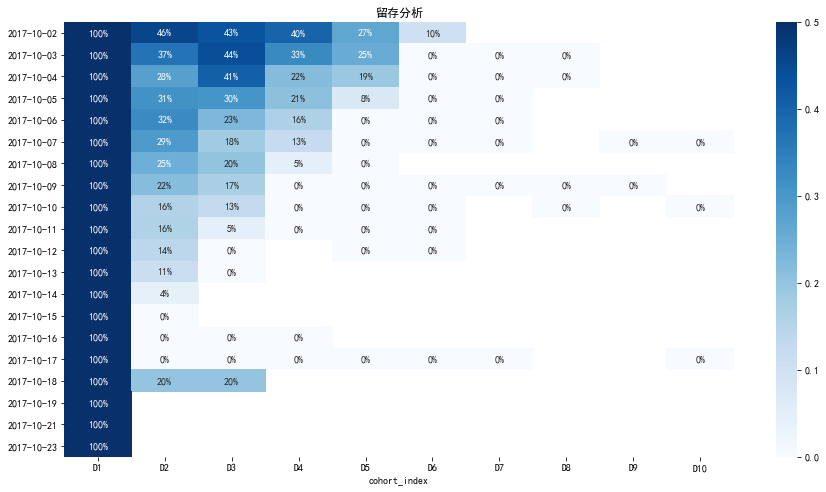

In [26]:
# 留存分析热力图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,8))
plt.title("留存分析")
sns.heatmap(data=retention_table,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="Blues")
plt.show()

**业务角度分析**

整体留存率不高，前三天有不错的三日留存率，之后的留存率都在下降
分析留存率下降原因如下：
* 客户因为推广活动，单纯为了薅羊毛
* 客户体验较差，内容没有吸引力
* 客户不是目标客户

**商业角度分析**
* 根据用户画像分析用户是否为目标用户，必要时进行用户调研
* 结合用户画像、喜好在和合理时间推送活动
* 实行创作激励计划，吸引优质创作者，提高内容质量

## R：获取收入——用户偏好分析

**数据准备**

选择用户id、点击时间戳、操作系统、国家、区域、来源、文章类型id、文章id字段

In [27]:
prefer_data = user_click_merge[['user_id','click_timestamp','click_os','click_country','click_region','click_referrer_type','category_id','click_article_id']]
prefer_data.head()

,user_id,click_timestamp,click_os,click_country,click_region,click_referrer_type,category_id,click_article_id
0,199999,1507029570190,17,1,13,1,281,160417
1,199999,1507029571478,17,1,13,1,4,5408
2,199999,1507029601478,17,1,13,1,99,50823
3,199998,1507029532200,17,1,25,5,281,157770
4,199998,1507029671831,17,1,25,5,209,96613


### 1、独立性检验

分别计算不同文章类型点击数与不同操作系统、国家、区域、来源间的相关性

#### 1.文章类型与操作系统

In [28]:
prefer_os = prefer_data.groupby(['category_id','click_os']).agg(
                                    os_counts = ("click_timestamp",lambda x : x.count())
).reset_index()
#prefer_os.head()
os_counts = prefer_os.pivot(index="category_id",columns="click_os",values="os_counts")
#处理缺失值
os_counts.fillna('1', inplace=True)
#转为数字类型
os_counts= os_counts.apply(pd.to_numeric, errors='ignore')
#prefer_counts.head()
#prefer_counts.dtypes
chi2_contingency(os_counts.values)

(140938.31764425628,
 0.0,
 2072,
 array([[8.54791774e+02, 6.08998711e-01, 1.82502526e+00, ...,
         1.91299503e+03, 7.56222671e+00, 3.52168779e+02],
        [5.17765664e+02, 3.68883548e-01, 1.10545685e+00, ...,
         1.15874201e+03, 4.58060250e+00, 2.13316163e+02],
        [3.89653215e+02, 2.77609487e-01, 8.31930049e-01, ...,
         8.72030694e+02, 3.44720907e+00, 1.60534649e+02],
        ...,
        [3.45531501e+00, 2.46174852e-03, 7.37727874e-03, ...,
         7.73287792e+00, 3.05687025e-02, 1.42356783e+00],
        [1.65589327e+02, 1.17974564e-01, 3.53541897e-01, ...,
         3.70583303e+02, 1.46494628e+00, 6.82217504e+01],
        [3.18952154e+00, 2.27238325e-03, 6.80979576e-03, ...,
         7.13804115e+00, 2.82172639e-02, 1.31406261e+00]]))

#### 2. 文章类型与国家

In [29]:
prefer_country = prefer_data.groupby(['category_id','click_country']).agg(
                                    country_counts = ("click_timestamp",lambda x : x.count())
).reset_index()
country_counts = prefer_country.pivot(index="category_id",columns='click_country',values="country_counts")
country_counts.fillna('1', inplace=True)
country_counts= country_counts.apply(pd.to_numeric, errors='ignore')
chi2_contingency(country_counts.values)

(61431.855038695416,
 0.0,
 2960,
 array([[3.08143396e+03, 6.43792573e+00, 4.96043359e+00, ...,
         8.07695700e+00, 5.91587851e+01, 3.00088503e+01],
        [1.86649047e+03, 3.89958934e+00, 3.00464075e+00, ...,
         4.89238565e+00, 3.58337417e+01, 1.81770026e+01],
        [1.40561680e+03, 2.93670306e+00, 2.26273510e+00, ...,
         3.68435819e+00, 2.69856771e+01, 1.36887386e+01],
        ...,
        [1.62886745e+01, 3.40313238e-02, 2.62211975e-02, ...,
         4.26953573e-02, 3.12717458e-01, 1.58628873e-01],
        [6.00764643e+02, 1.25515530e+00, 9.67099460e-01, ...,
         1.57470524e+00, 1.15337557e+01, 5.85060607e+00],
        [1.72468318e+01, 3.60331664e-02, 2.77636209e-02, ...,
         4.52068489e-02, 3.31112603e-01, 1.67959983e-01]]))

#### 3. 文章类型与区域

In [30]:
prefer_region = prefer_data.groupby(['category_id','click_region']).agg(
                                    region_counts = ("click_timestamp",lambda x : x.count())
).reset_index()
region_counts = prefer_region.pivot(index="category_id",columns='click_region',values="region_counts")
region_counts.fillna('1', inplace=True)
region_counts= region_counts.apply(pd.to_numeric, errors='ignore')
chi2_contingency(region_counts.values)

(1220666.7354949815,
 0.0,
 7992,
 array([[8.02271712e+00, 1.96141466e+01, 5.06190563e+00, ...,
         2.06174780e+01, 2.02810669e+01, 1.30974103e+02],
        [4.85953139e+00, 1.18807082e+01, 3.06610453e+00, ...,
         1.24884475e+01, 1.22846761e+01, 7.93338162e+01],
        [3.65712167e+00, 8.94102577e+00, 2.30744828e+00, ...,
         9.39839018e+00, 9.24503858e+00, 5.97039910e+01],
        ...,
        [8.23226571e-02, 2.01264564e-01, 5.19411958e-02, ...,
         2.11559943e-01, 2.08107963e-01, 1.34395068e+00],
        [1.55415198e+00, 3.79963101e+00, 9.80586818e-01, ...,
         3.99399528e+00, 3.92882608e+00, 2.53721599e+01],
        [7.98280311e-02, 1.95165638e-01, 5.03672202e-02, ...,
         2.05149035e-01, 2.01801661e-01, 1.30322491e+00]]))

#### 4. 文章类型与渠道

In [31]:
prefer_referrer = prefer_data.groupby(['category_id','click_referrer_type']).agg(
                                    referrer_counts = ("click_timestamp",lambda x : x.count())
).reset_index()
referrer_counts = prefer_referrer.pivot(index="category_id",columns='click_referrer_type',values="referrer_counts")
referrer_counts.fillna('1', inplace=True)
referrer_counts= referrer_counts.apply(pd.to_numeric, errors='ignore')
chi2_contingency(referrer_counts.values)

(374203.4816689113,
 0.0,
 1776,
 array([[1.21569367e+03, 1.77074721e+03, 1.08813542e+00, ...,
         1.04141656e+02, 2.71639603e+01, 7.36758356e+01],
        [7.36371663e+02, 1.07257947e+03, 6.59106902e-01, ...,
         6.30808290e+01, 1.64537919e+01, 4.46270298e+01],
        [5.54168819e+02, 8.07187628e+02, 4.96021929e-01, ...,
         4.74725335e+01, 1.23825764e+01, 3.35848181e+01],
        ...,
        [4.15815621e+00, 6.05666023e+00, 3.72185622e-03, ...,
         3.56205913e-01, 9.29115557e-02, 2.52000682e-01],
        [2.35124833e+02, 3.42476606e+02, 2.10454052e-01, ...,
         2.01418253e+01, 5.25372615e+00, 1.42494931e+01],
        [4.91418461e+00, 7.15787119e+00, 4.39855735e-03, ...,
         4.20970625e-01, 1.09804566e-01, 2.97818987e-01]]))

从以上分析可以看出，**操作系统、国家、区域、渠道**都和**文章类型**有很强的相关性，接下来选择**国家、渠道**作进一步分析

### 2、用户偏好分析

#### 1.点击量top20的文章类型

In [32]:
type_count = prefer_data.groupby('category_id').agg(
                                    counts = ("user_id",lambda x : x.count()                                   
)).sort_values(ascending=False,by = 'counts').reset_index()
type_count = pd.DataFrame(type_count)
type_count['rank'] = range(1,len(type_count)+1)
type_count[:20]

,category_id,counts,rank
0,281,179455,1
1,375,152587,2
2,250,94229,3
3,412,92587,4
4,437,90056,5
5,331,59836,6
6,399,49393,7
7,209,45677,8
8,418,39372,9
9,323,36449,10


#### 1. 不同国家用户偏好

In [33]:
prefer_country_data = prefer_data[prefer_data['category_id'].isin(type_count['category_id'][:20])].groupby(['category_id','click_country']).agg(
                                    counts = ("click_timestamp",lambda x : x.count())).reset_index()
#prefer_country_data.head()
prefer_country = prefer_country_data.pivot(index="category_id",columns='click_country',values="counts")
prefer_country = prefer_country.apply(pd.to_numeric, errors='ignore')
prefer_country.head()

click_country,1,2,3,4,5,6,7,8,9,10,11
category_id,,,,,,,,,,,
26,30826,41,35,17,33,53,26,45,59,452,246
118,34242,50,37,22,28,47,26,56,65,467,246
136,26412,31,35,22,13,26,25,43,60,361,236
209,43866,69,46,35,48,103,55,159,112,792,392
250,90826,185,131,86,81,141,107,233,242,1359,838


从该结果可以看出，国家1的用户活跃度远远高于其他国家，为了能更好的分析接下来做归一化处理

In [34]:
max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

In [35]:
prefer_country_scaler = prefer_country.apply(max_min_scaler)
prefer_country_scaler.head(5)

click_country,1,2,3,4,5,6,7,8,9,10,11
category_id,,,,,,,,,,,
26,0.055054,0.017857,0.032407,0.032710,0.093897,0.0432,0.039683,0.002699,0.029173,0.025047,0.028642
118,0.078809,0.032468,0.037037,0.056075,0.070423,0.0336,0.039683,0.017544,0.038898,0.027585,0.028642
136,0.024360,0.001623,0.032407,0.056075,0.000000,0.0000,0.035714,0.000000,0.030794,0.009646,0.024550
209,0.145734,0.063312,0.057870,0.116822,0.164319,0.1232,0.154762,0.156545,0.115073,0.082586,0.088380
250,0.472292,0.251623,0.254630,0.355140,0.319249,0.1840,0.361111,0.256410,0.325770,0.178541,0.270867


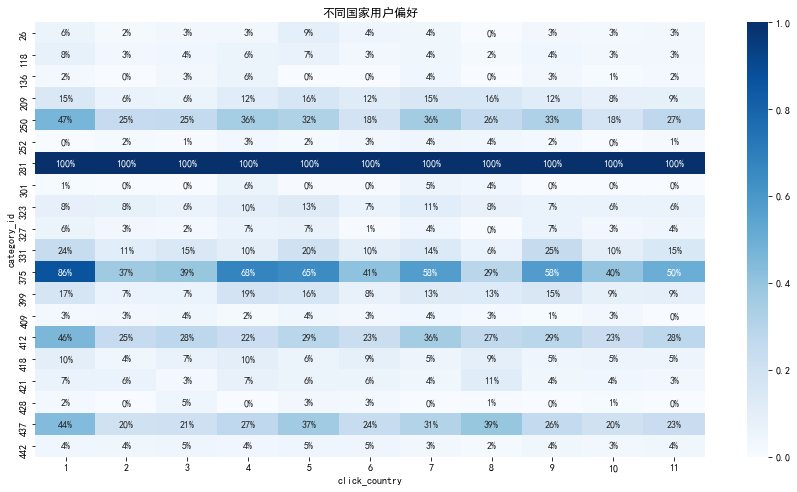

In [36]:
#绘制热力图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,8))
plt.title("不同国家用户偏好")
sns.heatmap(data=prefer_country_scaler,annot = True,fmt = '.0%',vmin = 0.0,vmax = 1,cmap="Blues")
plt.show()

**业务角度分析**

* 国家1的用户群体最多，可以针对国家文化、民族信仰推送相关内容
* 不同国家对不同类型文章的偏好程度与TOP20排名基本一致
* 类型id为281的新闻在每个国家都是最欢迎，可以进一步分析成功的原因，总结经验

**商业角度分析**

* 对于偏好程度高于80%的类型和国家继续优化推广运营策略
* 对于偏好程度在80%到50%之间的类型和国家有一定用户基础，可以通过优化内容等方式提高用户的兴趣
* 对于偏好程度在10%到50%之间的类型和国家有较大的上升空间，可以通过不同的策略分析未来发展潜力
* 对于偏好程度低于10%的类型和国家，视重要程度、整体规划来选择放弃或保留

#### 3. 不同渠道用户偏好

In [37]:
prefer_referrer_data = prefer_data[prefer_data['category_id'].isin(type_count['category_id'][:20])].groupby(['category_id','click_referrer_type']).agg(
                                    counts = ("click_timestamp",lambda x : x.count())).reset_index()
#prefer_country_data.head()
prefer_referrer = prefer_referrer_data.pivot(index="category_id",columns='click_referrer_type',values="counts")
prefer_referrer = prefer_referrer.apply(pd.to_numeric, errors='ignore')
prefer_referrer.head()

click_referrer_type,1,2,3,4,5,6,7
category_id,,,,,,,
26,11766.0,18227.0,2.0,119.0,874.0,162.0,683.0
118,12388.0,20808.0,2.0,123.0,1042.0,240.0,683.0
136,9696.0,14396.0,2.0,188.0,2061.0,98.0,823.0
209,15211.0,28443.0,1.0,123.0,824.0,265.0,810.0
250,39003.0,48725.0,3.0,965.0,1936.0,1799.0,1798.0


In [38]:
prefer_referrer_scaler = prefer_referrer.apply(max_min_scaler)
prefer_referrer_scaler.head(5)

click_referrer_type,1,2,3,4,5,6,7
category_id,,,,,,,
26,0.089275,0.063281,0.090909,0.038501,0.142894,0.064037,0.070789
118,0.099337,0.091765,0.090909,0.042553,0.185915,0.108634,0.070789
136,0.055791,0.021002,0.090909,0.108409,0.446863,0.027444,0.111240
209,0.145002,0.176025,0.000000,0.042553,0.130090,0.122927,0.107483
250,0.529861,0.399859,0.181818,0.895643,0.414853,1.000000,0.392950


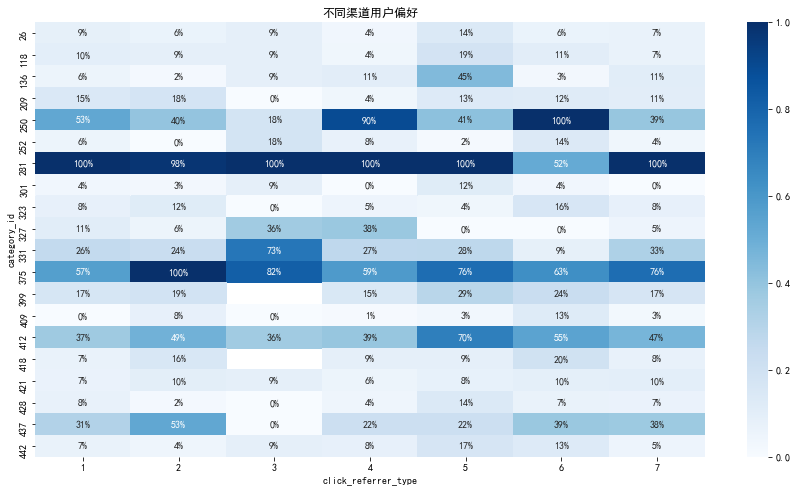

In [39]:
#绘制热力图

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,8))
plt.title("不同渠道用户偏好")
sns.heatmap(data=prefer_referrer_scaler,annot = True,fmt = '.0%',vmin = 0.0,vmax = 1,cmap="Blues")
plt.show()

**业务角度分析**

* 类型id为281的文章在渠道6的偏好程度只有52%远远低于其他渠道，需进一步分析原因
* 渠道4 6与类型250、渠道3和类型331、渠道2 3 5 7和类型375、渠道5和类型412、偏好程度远超其他渠道和类型，可以加大这方面的推送，并进一步分析受欢迎的原因

**商业角度分析**

* 对于偏好程度高于80%的类型和国家继续优化推广运营策略
* 对于偏好程度在80%到50%之间的类型和国家有一定用户基础，可以通过优化内容等方式提高用户的兴趣
* 对于偏好程度在10%到50%之间的类型和国家有较大的上升空间，可以通过不同的策略分析未来发展潜力
* 对于偏好程度低于10%的类型和国家，视重要程度、整体规划来选择放弃或保留

# 三、“RFM”用户价值模型

**数据准备**

选择用户id、点击时间戳、文章类型id字段

In [40]:
rfm_data = user_click_merge[['user_id','click_timestamp','category_id']]
rfm_data.head()

,user_id,click_timestamp,category_id
0,199999,1507029570190,281
1,199999,1507029571478,4
2,199999,1507029601478,99
3,199998,1507029532200,281
4,199998,1507029671831,209


In [41]:
rfm_classify = rfm_data.groupby('user_id').agg(
                    最近一次阅读 = ("click_timestamp",lambda x : time.time()-(x.max()/1000)),#当前时间和用户点击时间的差值
                    阅读频率 = ("click_timestamp",lambda x : x.count()),#阅读点击次数
                    阅读兴趣 = ("category_id",lambda x : x.nunique())#用户点击文章类型数
).reset_index().rename(columns = {'user_id':'用户ID'})
rfm_classify.head()

,用户ID,最近一次阅读,阅读频率,阅读兴趣
0,0,1.388018e+08,2,2
1,1,1.388021e+08,2,2
2,2,1.388020e+08,2,2
3,3,1.388021e+08,2,2
4,4,1.388018e+08,2,2


绘三维散点图查看数据分布

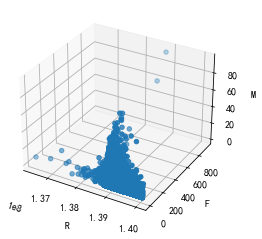

In [42]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
ax.scatter3D(rfm_classify.最近一次阅读, 
            rfm_classify.阅读频率,
            rfm_classify.阅读兴趣)
plt.show()

排除离群点、并归一化

1. 取对数实现线性变换
2. 对于离群点，即大于99分位的值，用99分位的值替代
3. 对于在99分位内的值，进行归一化

In [43]:
def stdFuc(data,cols,quantile=0.99):
#第一步
 data['log'] = [math.log(i+1) for i in data[cols].reset_index(drop=True).tolist()] 
 Q = np.quantile(data['log'],quantile)
 P = np.quantile(data['log'],1-quantile)
#第二步
 data.loc[data['log']>Q,'log'] = Q 
 data.loc[data['log']<P,'log'] = P 
#第三步
 if (Q-min(data['log'])>0):
  std = (data['log']-min(data['log']))/(Q-min(data['log'])) 
 else:
  std = data['log']+1-data['log'] 
 return std

In [44]:
rfm_classify.loc[:,'最近一次阅读']=stdFuc(rfm_classify,'最近一次阅读',0.99) 
rfm_classify.loc[:,'阅读频率']=stdFuc(rfm_classify,'阅读频率',0.99)
rfm_classify.loc[:,'阅读兴趣']=stdFuc(rfm_classify,'阅读兴趣',0.99)
rfm_classify.head()

,用户ID,最近一次阅读,阅读频率,阅读兴趣,log
0,0,0.0,0.133179,0.166015,1.098612
1,1,0.0,0.133179,0.166015,1.098612
2,2,0.0,0.133179,0.166015,1.098612
3,3,0.0,0.133179,0.166015,1.098612
4,4,0.0,0.133179,0.166015,1.098612


In [45]:
#修改列名
cluster_data = rfm_classify.loc[:,['最近一次阅读','阅读频率','阅读兴趣']].rename(columns = {'最近一次阅读':'R','阅读频率':'F','阅读兴趣':'M'})

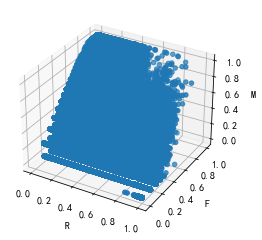

In [46]:
fig = plt.figure()
#创建3d绘图区域
ax = plt.axes(projection='3d')
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
ax.scatter3D(cluster_data.R,
            cluster_data.F,
            cluster_data.M)
plt.show()

#### 1、KMmeans分群

k值确定选择手肘法和轮廓系数法

1. 手肘法

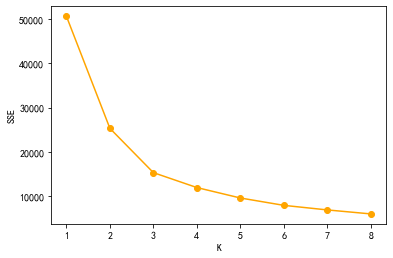

In [47]:
#SSE找到最优的K值
K_RFM=cluster_data.loc[:,['R','F','M']]
SSE=[]
for k in range(1,9):
 clf=KMeans(n_clusters=k,random_state=123)
 clf.fit(K_RFM)
 SSE.append(clf.inertia_) #误差
plt.xlabel('K')
plt.ylabel('SSE')
SSE
plt.plot(range(1,9),SSE,'o-',color='orange')

手肘法分析可以看出，k=3效果较好

2. 轮廓系数法

In [ ]:
K_RFM = cluster_data.loc[:,['R','F','M']]
Scores=[]
for k in range(2,9):
 clf=KMeans(n_clusters=k,random_state=123)
 clf.fit(K_RFM)
 Scores.append(silhouette_score(K_RFM,clf.labels_,metric='euclidean'))#轮廓系数
plt.xlabel('K')
plt.ylabel('score')
plt.plot(range(2,9),Scores,'o-',color='orange')

In [48]:
# 1.设定初始簇的数量
n_clusters = 3
# 2.实例化KMeans类
k = KMeans(n_clusters=n_clusters,n_init=10,random_state=10)
y_pred = k.fit(cluster_data)
# 3.添加标签
tag = y_pred.labels_
cluster_labels = pd.DataFrame(tag)
rfm_merge_data = pd.concat((cluster_data,cluster_labels),axis = 1).rename(columns = {0:'k_tag'})
rfm_merge_data.head()
#merge_data[0].value_counts()

,R,F,M,k_tag
0,0.0,0.133179,0.166015,2
1,0.0,0.133179,0.166015,2
2,0.0,0.133179,0.166015,2
3,0.0,0.133179,0.166015,2
4,0.0,0.133179,0.166015,2


In [49]:
#查看质心
centroid = y_pred.cluster_centers_
print(centroid)

[[0.80464999 0.1818083  0.16034677]
 [0.19813523 0.63370004 0.65608957]
 [0.29772703 0.24262861 0.24533495]]


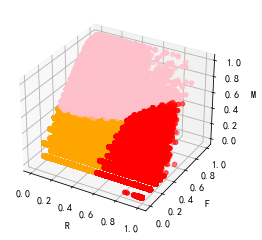

In [50]:
# 绘制点的分布
color = ["red","pink","orange","gray"]
fig = plt.figure()
#创建3d绘图区域
ax1= plt.axes(projection='3d')
ax1.set_xlabel('R')
ax1.set_ylabel('F')
ax1.set_zlabel('M')

# 画出不同簇的图
for i in range(3):
    ax1.scatter3D(rfm_merge_data.loc[rfm_merge_data['k_tag']==i].R,   
                  rfm_merge_data.loc[rfm_merge_data['k_tag']==i].F,     
                  rfm_merge_data.loc[rfm_merge_data['k_tag']==i].M,
                marker='o',
                color=color[i]
                )
# 绘制每个簇的质心
# ax1.scatter3D(centroid[:,0], centroid[:,1],centroid[:,2], marker='x',color="black", alpha=1,s=200)
plt.show()


根据分类结果将用户分为价值用、保持用户、挽留用户并统计相应的人群数及对应比例

In [51]:
kmeans_rfm = rfm_merge_data.groupby(['k_tag']).agg(
                                人群数 = ("k_tag",lambda x : x.count()),
                                人群比例 = ("k_tag",lambda x : format(x.count()/rfm_merge_data.k_tag.count(),'.2%'))
                                ).reset_index().rename(columns = {'k_tag':'人群'})
kmeans_rfm['人群'] = kmeans_rfm.人群.map(lambda x: '价值用户' if x ==0                                 
                                else '保持用户' if x ==1
                                else '挽留用户' if x ==2
                                else 0)
kmeans_rfm.head()

,人群,人群数,人群比例
0,价值用户,75469,30.19%
1,保持用户,68958,27.58%
2,挽留用户,105573,42.23%


#### 2、三维度交叉分群

依次根据R、F、M的均值将用户分为价值用户、发展用户、保留用户、挽留用户四个大类并分别细分为重要用户和一般用户

In [52]:
def cross(R,F,M,rmean,fmean,mmean):
    if R >=rmean:
            if F >=fmean:
                if M >=mmean:
                     return '重要价值用户'
                else: return '一般价值用户'
            elif M >mmean:
                    return '重要发展用户'
            else: return '一般发展用户'
    elif F >=fmean:
        if  M >=mmean:
             return '重要保留用户'
        else: return '一般保留用户'
    elif M >mmean:
            return '重要挽留用户'
    else: return '一般挽留用户'        


In [53]:
rmean = rfm_merge_data.R.mean()
fmean = rfm_merge_data.F.mean()
mmean = rfm_merge_data.M.mean()
rfm_merge_data['cross_tag'] = rfm_merge_data.apply(lambda x: cross(x.R, x.F, x.M,rmean,fmean,mmean), axis = 1)

计算并统计每个人群对应的人群数和人群比例

In [54]:
cross_rfm = rfm_merge_data.groupby(['cross_tag']).agg(
                                人群数 = ("cross_tag",lambda x : x.count()),
                                人群比例 = ("cross_tag",lambda x : format(x.count()/rfm_merge_data.cross_tag.count(),'.2%'))
                                ).reset_index().rename(columns = {'cross_tag':'人群'})
cross_rfm.head(8)

,人群,人群数,人群比例
0,一般价值用户,4709,1.88%
1,一般保留用户,4091,1.64%
2,一般发展用户,84839,33.94%
3,一般挽留用户,46702,18.68%
4,重要价值用户,22611,9.04%
5,重要保留用户,71892,28.76%
6,重要发展用户,6213,2.49%
7,重要挽留用户,8943,3.58%


#### 3、矩阵法分群

矩阵法选择阅读频率和阅读兴趣作为分群基础，
参考波士顿矩阵将用户分为金牛用户、勤劳用户、潜力用户、边缘用户

<function matplotlib.pyplot.show(close=None, block=None)>

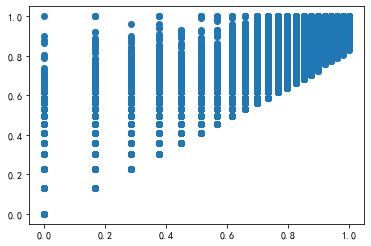

In [55]:
#查看数据分布
plt.scatter(rfm_merge_data.M,rfm_merge_data.F)
plt.show

In [56]:
#分群
def matrix(F,M,fmed,mmed):
    if F >= 0.5:
        if M >= 0.5:
            return '金牛用户'
        else: return '勤劳用户'
    elif M >= 0.5:
          return '潜力用户'
    else: return '边缘用户'       

In [57]:
fmedian = rfm_merge_data.F.quantile()
mmedian = rfm_merge_data.M.quantile()
rfm_merge_data['matrix_tag'] = rfm_merge_data.apply(lambda x: matrix(x.F, x.M, fmedian, mmedian), axis = 1)

In [58]:
matrix_rfm = rfm_merge_data.groupby(['matrix_tag']).agg(
                                人群数 = ("matrix_tag",lambda x : x.count()),
                                人群比例 = ("matrix_tag",lambda x : format(x.count()/rfm_merge_data.cross_tag.count(),'.2%'))
                                ).reset_index().rename(columns = {'matrix_tag':'人群'})
matrix_rfm.head(4)

,人群,人群数,人群比例
0,勤劳用户,3944,1.58%
1,潜力用户,16102,6.44%
2,边缘用户,181005,72.40%
3,金牛用户,48949,19.58%


#### 4、可视化比较

In [59]:
kmeans = [list(z) for z in zip(kmeans_rfm.人群.tolist(), kmeans_rfm.人群数.tolist())] 
cross  = [list(z) for z in zip(cross_rfm.人群.tolist(), cross_rfm.人群数.tolist())]
matrix = [list(z) for z in zip(matrix_rfm.人群.tolist(), matrix_rfm.人群数.tolist())]

pie1 = (Pie()
       .add('', 
            kmeans,
            center=['170','center'],
            radius="30%")
       .set_global_opts(legend_opts=opts.LegendOpts(is_show=False),
                    title_opts=opts.TitleOpts(title='KMmeans分群',
                                              pos_left='100')                       
                      )
       )
pie2 = (Pie()
       .add('', 
            cross,
            center=['center','center'],
            radius="30%")
       .set_global_opts(legend_opts=opts.LegendOpts(is_show=False),
                        title_opts=opts.TitleOpts(title='三维度交叉分群',
                                                  pos_left='center')
                       )
       )
pie3 = (Pie()
       .add('矩阵法分群', 
            matrix,
            center=[770,'center'],
            radius="30%")
       .set_global_opts(legend_opts=opts.LegendOpts(is_show=False),
                        title_opts=opts.TitleOpts(title='矩阵法分群',
                                                  pos_left='710')
                       )
       )
grid = (Grid()
        .add(pie1,grid_opts=opts.GridOpts(pos_bottom="30%", pos_left="30%"))
        .add(pie2,grid_opts=opts.GridOpts(pos_left="30%"))
        .add(pie3,grid_opts=opts.GridOpts(pos_left="30%"))
        )
grid.render_notebook()

**整体分析**

* 整体来看使用KMeans分类结果较平均，其他分类都存在比例失衡的情况
* 价值用户、金牛用户可为优质用户，继续保持相应策略
* 发展用户、勤劳用户需要调整策略激发兴趣
* 保持用户、潜力用户需要反复分析，运营激活
* 挽留用户、边缘用户需要分析用户成分，分析是否为目标用户，推送目标内容